In [165]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

In [166]:
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
mp = ground_truth

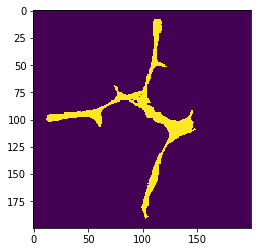

In [167]:
plt.imshow(mp)

In [168]:
mp.shape

(200, 200)

In [169]:
#min x which is unblocked
def get_min_x_unblocked(mp):
    for i in range(199, -1, -1):
        for j in range(199, -1, -1):
            if mp[i, j] > 0.0:
                return i, j
lowest_ub = get_min_x_unblocked(mp)
print(lowest_ub)

(191, 103)


In [170]:
def is_on_border(mp, pos):
    for di in range(-1, 2):
        for dj in range(-1, 2):
            if mp[pos[0] + di, pos[1] + dj] == 0.0:
                return True
    return False
is_on_border(mp, lowest_ub)

True

In [171]:
is_on_border(mp, (107, 130))

False

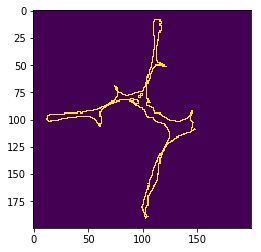

In [172]:
def build_border_map(mp):
    border_mp = np.copy(mp)
    for i in range(mp.shape[0]):
        for j in range(mp.shape[1]):
            if mp[i, j] > 0.0 and not is_on_border(mp, (i, j)):
                border_mp[i, j] = 0.0
    return border_mp
plt.imshow(build_border_map(mp))

In [173]:
def traverse_border(border_map, border_path, current, prev):
    next_border_pos = []
    border_path.append(current)
    found_next = False
    new_pos = None
    for di in range(-1, 2):
        if found_next:
            break
        for dj in range(-1, 2):
            new_pos = (current[0] + di, current[1] + dj)
            if border_map[current[0] + di, current[1] + dj] == 1.0:
                found_next = True
                if not new_pos in border_path:
                    break
    
    #print (current)
    prev = current
    current = new_pos

    if found_next:
        traverse_border(border_map, border_path, current, prev)
    return border_path
                    
def build_border_path(border_map):
    lowest_ub = get_min_x_unblocked(border_map)
    path = []
    border_path = traverse_border(border_map, path, lowest_ub, None)
    return border_path

bpath = build_border_path(build_border_map(mp))
len(bpath)

136

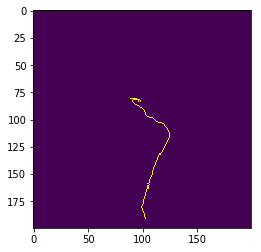

In [174]:
border_path_map = np.zeros(mp.shape)
for pos in bpath:
    border_path_map[pos[0], pos[1]] = 1.0
    
plt.imshow(border_path_map)

In [175]:
DIST_FROM_WALL = 2

def median_path(mp, left_right = True):
    lmeans = []
    rmeans = []
    border_mp = np.copy(mp)
    for i in range(mp.shape[0]):
        start = None
        end = None
        inside = False
        for j in range(mp.shape[1]):
            if left_right == True:
                pos = (i, j)
            else:
                pos = (j, i)
            if mp[pos] == 1.0 and not inside:
                inside = True
                start = j
            if mp[pos] == 0.0 and inside:
                inside = False
                end = j
            if start != None and end != None:
                wh = start + DIST_FROM_WALL
                if left_right == True:
                    new_pos = (i, wh)
                else:
                    new_pos = (wh, i)
                if mp[new_pos] == 1.0:
                    lmeans.append(new_pos)
                
                wh = end - DIST_FROM_WALL
                if left_right == True:
                    new_pos = (i, wh)
                else:
                    new_pos = (wh, i)
                if mp[new_pos] == 1.0:
                    rmeans.append(new_pos)
                
                start = None
                end = None
    return lmeans + rmeans

lrmedians = median_path(mp)
upmedians = median_path(mp, False)

medians = lrmedians + upmedians

In [177]:
def median_path(mp, left_right = True):
    lmeans = []
    rmeans = []
    for i in range(mp.shape[0]):
        start = None
        end = None
        inside = False
        for j in range(mp.shape[1]):
            if left_right == True:
                pos = (i, j)
            else:
                pos = (j, i)
            if mp[pos] == 1.0 and not inside:
                inside = True
                start = j
            if mp[pos] == 0.0 and inside:
                inside = False
                end = j
            if start != None and end != None:
                #wh = start + DIST_FROM_WALL
                wh = int((start + end)/2)
                if left_right == True:
                    new_pos = (i, wh)
                else:
                    new_pos = (wh, i)
                if mp[new_pos] == 1.0:
                    lmeans.append(new_pos)
                
#                wh = end - DIST_FROM_WALL
#                if left_right == True:
#                    new_pos = (i, wh)
#                else:
#                    new_pos = (wh, i)
#                if mp[new_pos] == 1.0:
#                    rmeans.append(new_pos)
                
                start = None
                end = None
    return lmeans + rmeans
lrmedians = median_path(mp)
upmedians = median_path(mp, False)

medians = lrmedians + upmedians

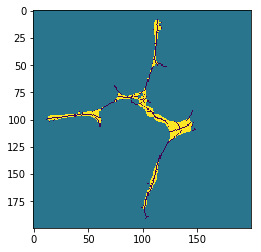

In [178]:
median_path_map = np.zeros(mp.shape)

median_path_map.fill(255)

for i in range(median_path_map.shape[0]):
    for j in range(median_path_map.shape[1]):
        if is_on_border(mp, (i, j)):
            median_path_map[i, j] = 100
for pos in medians:
    median_path_map[pos[0], pos[1]] = 1

plt.imshow(median_path_map)

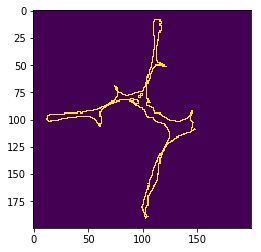

In [17]:
plt.imshow(build_border_map(mp))

In [160]:
MIN_DIST_TO_MOVE = 3

def distance(pos1, pos2):
    return np.sqrt(np.square(pos1[0] - pos2[0]) + np.square(pos1[1] - pos2[1]))

def sign_changes(start, end, new_pos):
    sc = 0
    if np.sign(new_pos[0] - end[0]) != np.sign(end[0] - start[0]):
        sc += 1
    if np.sign(new_pos[1] - end[1]) != np.sign(end[1] - start[1]):
        sc += 1
    return sc

def find_min_not_visited(prev, pos, not_visited):
    min_dist = None
    min_pos = None
    min_sc = None
    for sc in range(3):
        for to in not_visited:
            dc = sign_changes(prev, pos, to)
            dist = distance(pos, to)
            if min_dist == None or (dc == sc and dist < min_dist and dist > MIN_DIST_TO_MOVE):
                min_dist = dist
                min_pos = to
                min_sc = dc
        if min_dist != None and min_dist < 20:
            break
    if min_dist != None and min_dist < 50:
        #print(min_dist, prev, pos, min_pos, min_sc)
        return min_pos
    else:
        return None

def greedy_path(current_path):
    #visited = set([])
    new_path = []
    not_visited = set(current_path)
    current = current_path[0]
    prev = current
    while current != None and current in not_visited:
        not_visited.discard(current)
        new_path.append(current)
        prev = current
        current = find_min_not_visited(prev, current, not_visited)
    print('not visited', len(not_visited))
    return new_path

apath = greedy_path(medians)
print('path length', len(apath))

not visited 4
path length 744


In [161]:
def create_path_images(path):
    path_images = []
    mp_3d = np.dstack((mp*0, mp*100, mp*0)).astype(np.float)

    for i in range(len(path)):
        new_mp = np.copy(mp_3d)
        for j in range(i):
            median = path[j]
            new_mp[median[0], median[1], 0] = 255
            new_mp[median[0], median[1], 1] = 0
            new_mp[median[0], median[1], 2] = 255
        path_images.append(new_mp)
    return path_images

path_images = create_path_images(apath)

In [162]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define pathname to save the output video
output = '../output/test_path.mp4'
clip = ImageSequenceClip(path_images, fps=60) # Note: output video will be sped up because 
# recording rate in simulator is fps=25
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_path.mp4
[MoviePy] Writing video ../output/test_path.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 745/745 [00:00<00:00, 905.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_path.mp4 

Wall time: 879 ms


In [159]:
from IPython.display import HTML
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

In [106]:
# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Perform translation and convert to integer since pixel values can't be float
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size=200, scale=10):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


In [155]:
# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def world_to_pix(xw, yw, xpos, ypos, yaw, rover_size=2000, scale=0.1):
    xwo = int(-xpos/scale)
    ywo = int(-ypos/scale)
    xwo, ywo = rotate_pix(xwo, ywo, -yaw)
    print('world origin', xwo, ywo)
    # Apply rotation
    xw_rot, yw_rot = rotate_pix(xw, yw, -yaw)
    print(xw_rot, yw_rot)
    # Apply translation
    xw_tran = xwo + xw_rot/scale
    yw_tran = ywo + yw_rot/scale
    #xw_tran, yw_tran = translate_pix(xw_rot, yw_rot, xwo, ywo, scale)
    print(xw_tran, yw_tran)
    
    return xw_tran, yw_tran

pos = (85, 35)
world = pix_to_world(pos[0], pos[1], 100, 100, 10)
print(world)

print(world_to_pix(world[0], world[1], 100, 100, 10))

(107, 104)
world origin -1158.45593068 -811.159575345
123.43384005 83.8396513029
75.8824698175 27.2369376838
(75.882469817531728, 27.236937683803262)


In [153]:
pix_to_world(-1158.45593068, -811.159575345, 100, 100, 10)

(0, 0)

In [137]:
x = np.zeros((5, 2))
x

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [145]:
x[0] = (6, 5)

In [146]:
x

array([[ 6.,  5.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [163]:
np.sign(-10)

-1